# EDAV

Exploratory analysis and visualization of the data available in the Yahoo Finance API.

*Last updated 11.20.22*

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import random
from statistics import mode
from collections import Counter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf
import networkx as nx


## Obtain index info, history, recommendations, and news from yfinance library

In [2]:
indices = ['MSFT', 'AAPL', 'GOOG', 'GOOGL', 'META', 'TSLA', 'SPY', 'NVDA', 'AMZN', 'COMP', 'FANG', '^GSPC']     # specify indices of interest
tickers = yf.Tickers(' '.join(indices))
info = {}
keys = ['sector', 'country', 'recommendationKey', 'grossProfits', 'totalDebt', 'totalRevenue', 'recommendationMean', 'shortName', 'longName', 'exchangeTimezoneShortName']
for index in indices:
    print(f'loading {index}', end=' -- ')
    
    # create and populate dictionary for this index
    index_dict = {}
    
    # obtain info
    index_info = tickers.tickers[index].info
    print(f'{index_info["shortName"]}')
    
    for k in keys:
        try:
            index_dict[k] = index_info[k]
        except:
            pass
    
    # obtain recommendations, if they exist
    recs = tickers.tickers[index].recommendations  
    try:
        recs = recs.reset_index().set_axis(['date', 'firm', 'to_grade', 'from_grade', 'action'], axis=1)
        # add a julian day column
        recs.insert(loc=list(recs.columns).index('date')+1, column='julian_day', value=[int(np.floor(d.to_julian_date())) for d in recs['date']])
        index_dict['recommendations'] = recs
    except:
        pass
    
    # obtain history
    index_dict['history'] = tickers.tickers[index].history(period='max').reset_index(drop=False)
    
    # obtain news
    try:
        index_dict['news'] = tickers.tickers[index].news
    except:
        pass
        
    info[index] = index_dict


loading MSFT -- Microsoft Corporation
loading AAPL -- Apple Inc.
loading GOOG -- Alphabet Inc.
loading GOOGL -- Alphabet Inc.
loading META -- Meta Platforms, Inc.
loading TSLA -- Tesla, Inc.
loading SPY -- SPDR S&P 500
loading NVDA -- NVIDIA Corporation
loading AMZN -- Amazon.com, Inc.
loading COMP -- Compass, Inc.
loading FANG -- Diamondback Energy, Inc.
loading ^GSPC -- S&P 500


## Explore recommendations

In [3]:
def std_txt(txt):
    txt = txt.strip().lower()
    txt = txt.replace(' ', '_')
    txt = txt.replace('-', '_')
    return txt


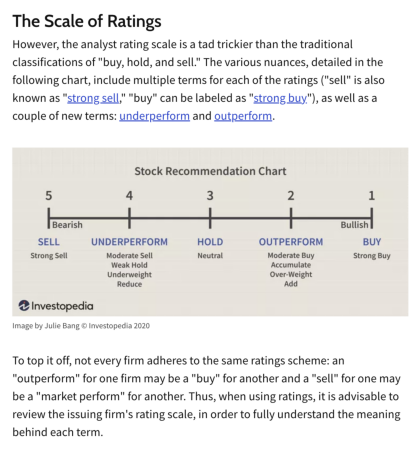

Source: https://www.investopedia.com/financial-edge/0512/understanding-analyst-ratings.aspx

Grade order (ascending):
	0 sell
	1 underperform
	2 hold
	3 outperform
	4 buy


In [4]:
# uncomment to learn order from selected indices
# note: fails if a topological ordering is not possible
# therefore use manual ordering

# grades_graph = nx.DiGraph()

# for index in indices:    
    
#     try:
#         recs = info[index]['recommendations']
#     except:
#         continue
        
#     for i in range(recs.shape[0]):
#         if recs.loc[i,'action'] == 'up':
#             n1, n2 = std_txt(recs.loc[i,'to_grade']), std_txt(recs.loc[i,'from_grade'])
            
#         elif recs.loc[i,'action'] == 'down':
#             n1, n2 = std_txt(recs.loc[i,'from_grade']), std_txt(recs.loc[i,'to_grade'])

#         if n1 != n2 and '' not in (n1, n2): 
#             # add edge to directed graph so the lower performance grade points to the higher performance grade
#             grades_graph.add_edge(n1, n2)

# # nx.draw(grades_graph, with_labels=True)

# grades = list(nx.topological_sort(grades_graph))
# grades.reverse()

plt.figure(figsize=(8,8))
plt.imshow(mpimg.imread('grades_explained.png'))
plt.axis('off')
plt.show()
print('Source: https://www.investopedia.com/financial-edge/0512/understanding-analyst-ratings.aspx')

grades = ['sell', 'underperform', 'hold', 'outperform', 'buy']

print('\nGrade order (ascending):')
for num, g in enumerate(grades):
    print(f'\t{num} {g}')
    
grades_vocab = {'sell': ['strong_sell'],
                'underperform': ['moderate_sell', 'weak_hold', 'underweight', 'reduce', 'negative'],
                'hold': ['neutral', '', 'equal_weight', 'sector_weight', 'market_perform', 'sector_perform', 'perform', 'in_line', 'long_term_buy', 'peer_perform', 'fair_value'],
                'outperform': ['moderate_buy', 'accumulate', 'overweight', 'add', 'market_outperform', 'mector_outperform', 'positive'],
                'buy': ['strong_buy']
               }

# previous order (ascending):
# sell, underweight, underperform, neutral, peer_perform, in-line, perform, market_perform,
# sector_perform, reduce, long-term_buy, outperform, hold, buy, sector_weight, equal-weight,
# accumulate, positive, market_outperform, strong_buy, overweight


In [5]:
# process all grades to take the appropriate name
for index in indices:
    try:
        recs = info[index]['recommendations']
    except:
        continue
        
    for i in range(recs.shape[0]):
        g = std_txt(recs.loc[i,'to_grade'])
        grade_found = False
        for key in grades_vocab.keys():
            if (key in g) or (g in grades_vocab[key]):
                recs.loc[i,'to_grade'] = key
                grade_found = True
                break
                
        if not grade_found:
            print(f'{g} not found; coerce to neutral')
            recs.loc[i,'to_grade'] = 'neutral'


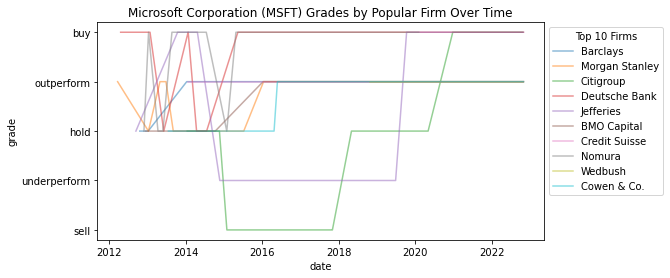

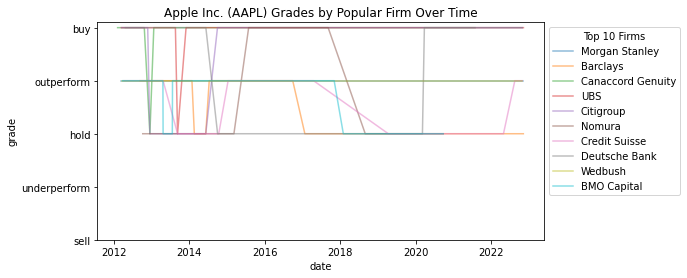

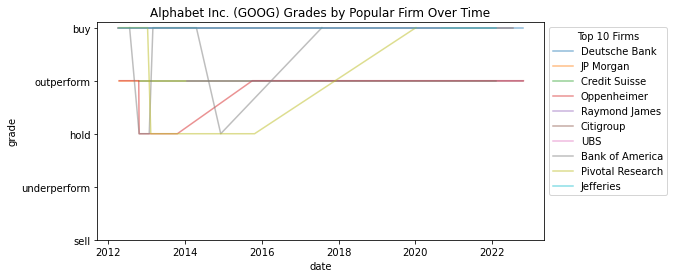

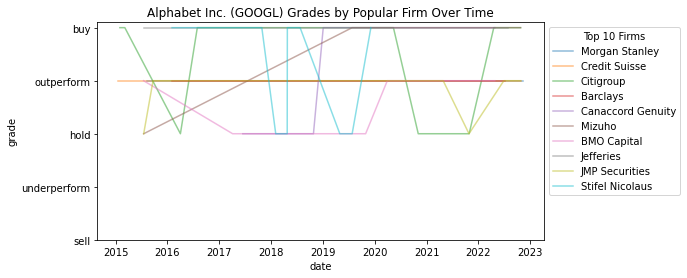

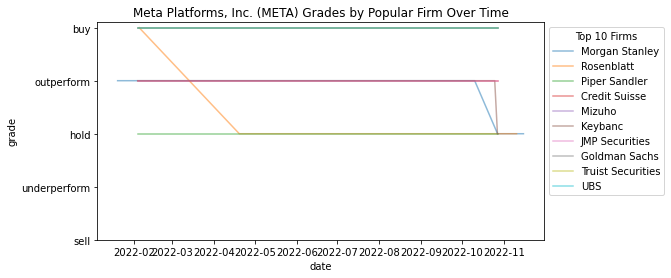

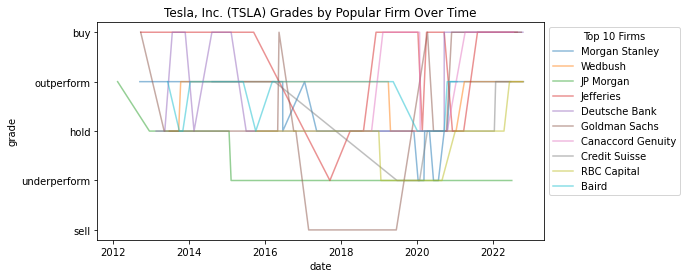

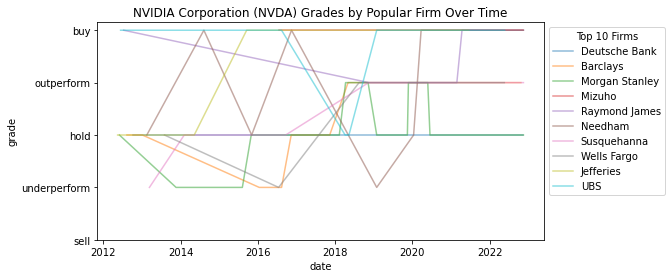

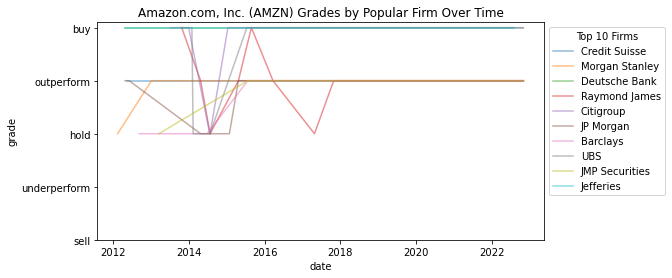

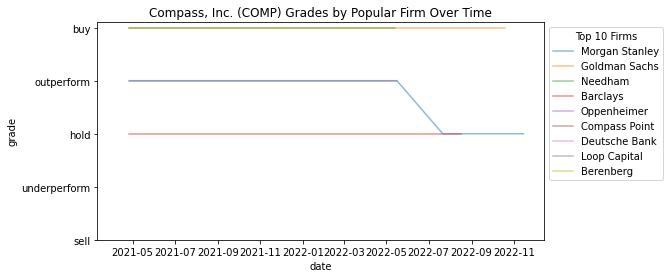

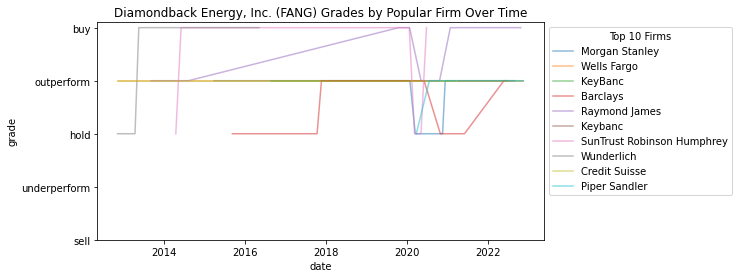

In [6]:
# display grades from popular firms for each index
num_firms = 10
for index in indices:
    try:
        recs = info[index]['recommendations']
    except:
        continue
        
    firms = Counter(recs['firm'])
    firms = dict(sorted(firms.items(), key=lambda item: item[1], reverse=True))
    
    plt.figure(figsize=(8,4))

    for f in list(firms.keys())[:num_firms]:
        tmp_df = recs[(recs['firm'] == f) & (recs['to_grade'] != '')].reset_index(drop=True)
        plt.plot(tmp_df['date'], [grades.index(std_txt(g)) for g in tmp_df['to_grade']], alpha=0.5, label=f)

    plt.title(f'{info[index]["shortName"]} ({index}) Grades by Popular Firm Over Time')
    plt.ylabel('grade')
    plt.yticks(ticks=list(range(len(grades))), labels=grades)
    plt.xlabel('date')
    plt.legend(bbox_to_anchor=[1,1], title=f'Top {num_firms} Firms')
    plt.show()


## Explore history

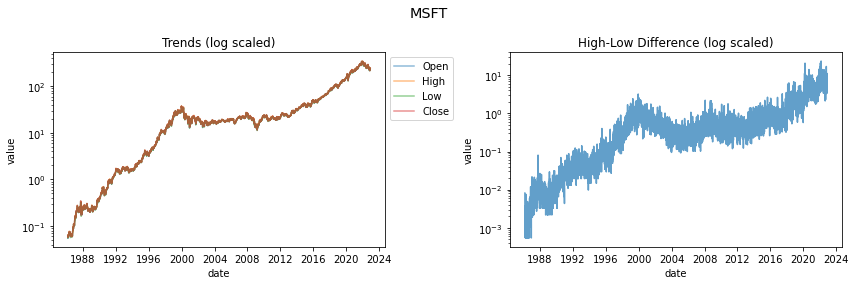

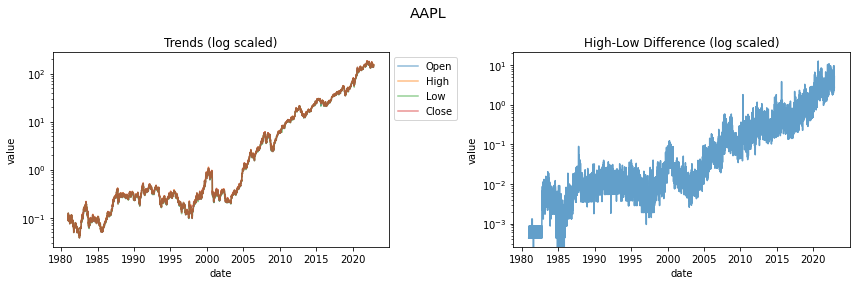

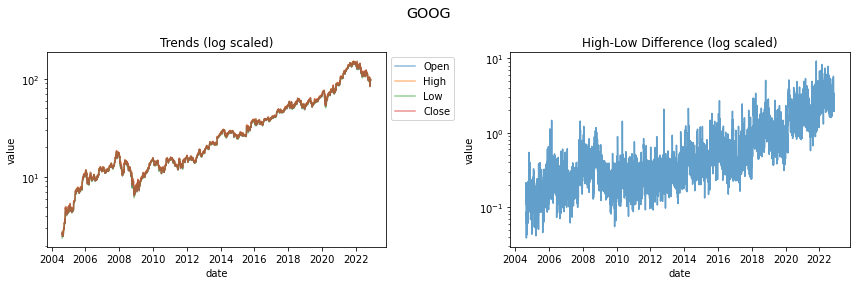

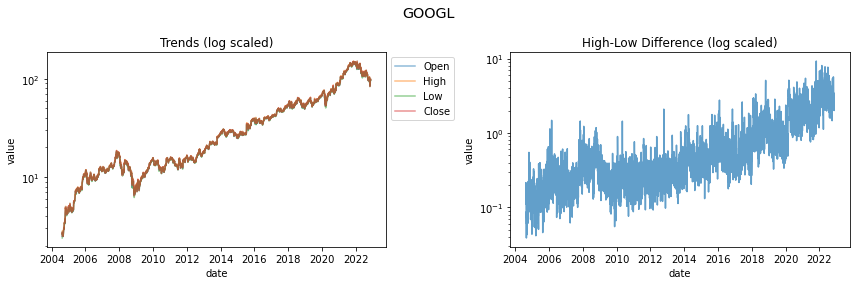

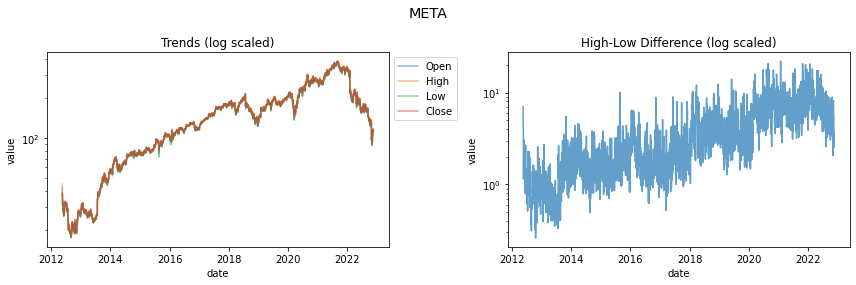

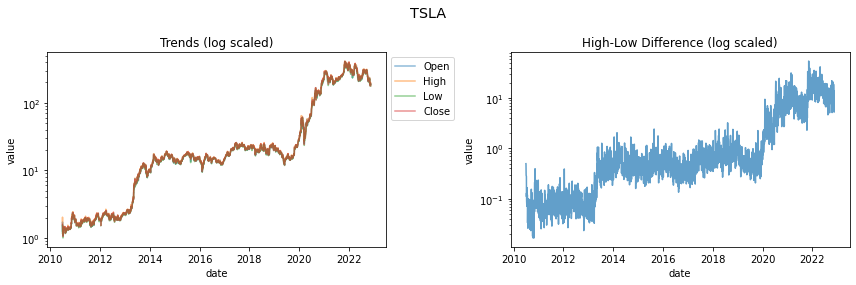

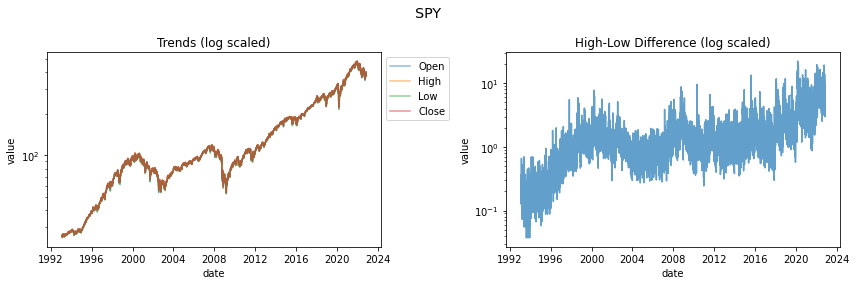

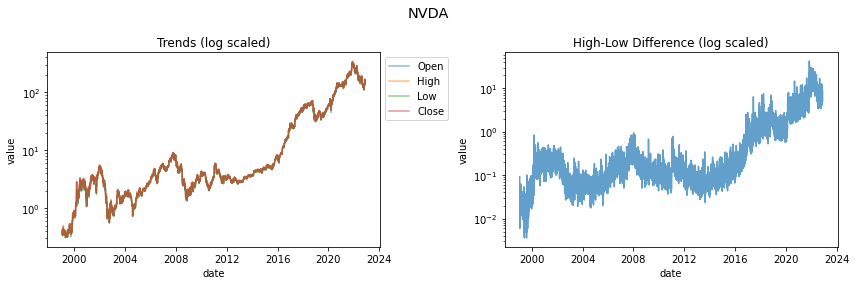

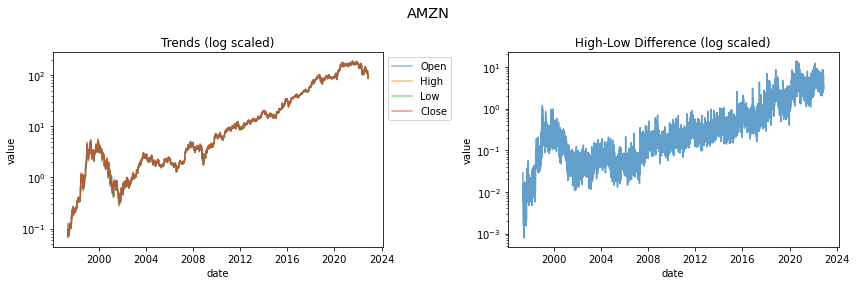

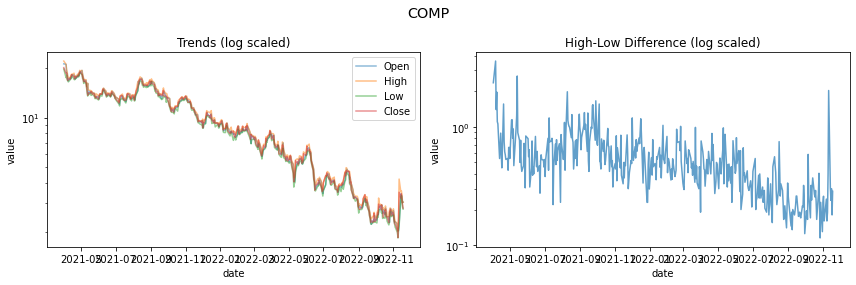

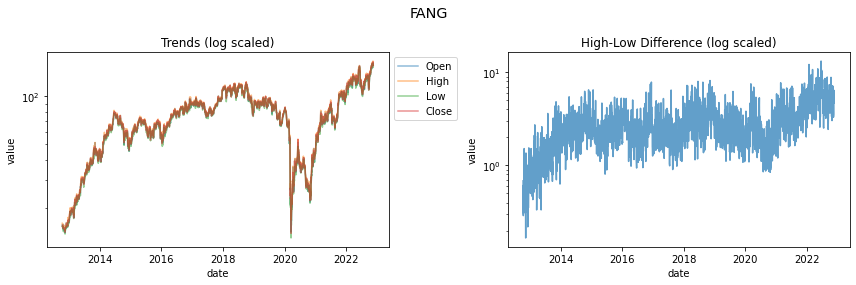

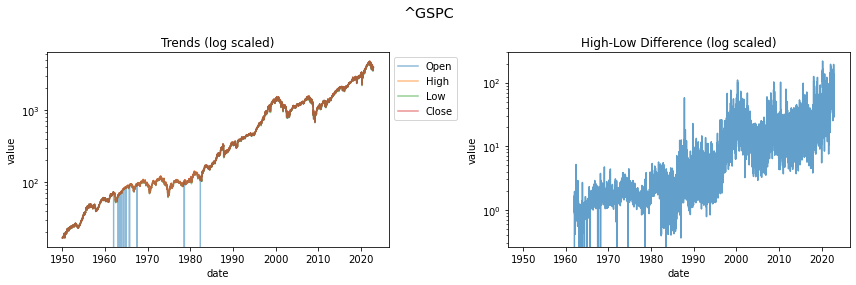

In [7]:
for index in indices:
    hist = info[index]['history']
    
    # plot the open, high, low, and close by date
    plt.figure(figsize=(12,4))
    plt.suptitle(f'{index}', fontsize='x-large')
    plt.subplot(1,2,1)
    for c in list(hist.columns)[1:5]:
        plt.plot(hist['Date'], hist[c], alpha=0.5, label=c)
    plt.title('Trends (log scaled)')
    plt.xlabel('date')
    plt.ylabel('value')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=[1.0, 1.0])
    
    plt.subplot(1,2,2)
    plt.plot(hist['Date'], [hist.loc[i,'High'] - hist.loc[i,'Low'] for i in range(hist.shape[0])], alpha=0.7, label='difference between high and low')
    plt.title('High-Low Difference (log scaled)')
    plt.xlabel('date')
    plt.ylabel('value')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()


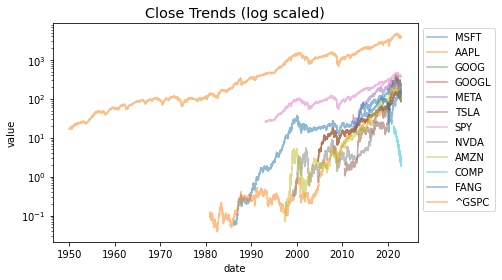

In [8]:
# visualize all close trends on one graph
plt.figure(figsize=(6,4))
plt.title('Close Trends (log scaled)', fontsize='x-large')
plt.xlabel('date')
plt.ylabel('value')
plt.yscale('log')

for index in indices:
    hist = info[index]['history']
    plt.plot(hist['Date'], hist['Close'], alpha=0.5, label=index)

plt.tight_layout()
plt.legend(bbox_to_anchor=[1.0, 1.0])
plt.show()


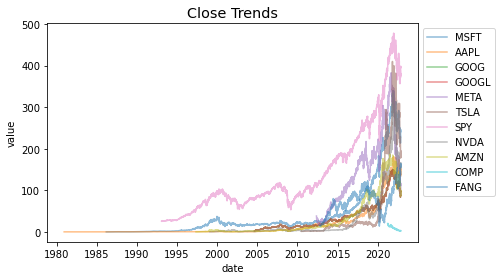

In [9]:
# repeat with all indices (excluding the overpowering ^GSPC) on same plot;
# use close trends only without log scale 
plt.figure(figsize=(6,4))
plt.title('Close Trends', fontsize='x-large')
plt.xlabel('date')
plt.ylabel('value')

for index in indices:
    if index == '^GSPC':
        continue
    hist = info[index]['history']
    plt.plot(hist['Date'], hist['Close'], alpha=0.5, label=index)

plt.tight_layout()
plt.legend(bbox_to_anchor=[1.0, 1.0])
plt.show()


## Explore news

In [10]:
for index in indices:
    try:
        news = info[index]['news']
    except:
        continue
        
    print(f'--{index}--')
    for num, d in enumerate(news):
        try:
            print(f'\t{num}')
            print(f'\t{d["title"]}')
            print(f'\t{d["link"]}')
            print(f'\t{" ".join(d["relatedTickers"])}\n')
        except:
            print(f'\t{num} err')
        

--MSFT--
	0
	Nvidia Scores a Huge Win -- Microsoft Will Be First Public Cloud to Adopt Its AI Stack
	https://finance.yahoo.com/m/aae9eadb-dc58-3ddf-90da-431f190515e1/nvidia-scores-a-huge-win-.html
	NVDA MSFT ORCL

	1
	At US$241, Is Microsoft Corporation (NASDAQ:MSFT) Worth Looking At Closely?
	https://finance.yahoo.com/news/us-241-microsoft-corporation-nasdaq-130132606.html
	MSFT

	2
	Al Gore’s Firm Dumps Intel Stock. It Also Sold Shopify and Microsoft Stock.
	https://finance.yahoo.com/m/28ef3dbd-9b3d-3b05-a012-3ef5da9f6305/al-gore%E2%80%99s-firm-dumps-intel.html
	MSFT SHOP INTC TWLO

	3
	3 Stocks Sharing Their Bounty With Shareholders
	https://finance.yahoo.com/m/de69d0d3-7c59-3942-94fe-330d171600e5/3-stocks-sharing-their-bounty.html
	MSFT MCD GPC

	4
	An Apple Bull Gets Nervous. The iPhone Isn’t Recession-Proof.
	https://finance.yahoo.com/m/3bb1eb99-7f4a-3e6c-842c-be1dc0655c20/an-apple-bull-gets-nervous..html
	AAPL AMZN MSFT

	5
	Analyst Report: Microsoft Corporation
	https://finance

## Customized stock data acquisition

In [ ]:
# uncomment for personalized data accquisition — specify periods, intervals, etc.
# common index codes at https://finance.yahoo.com/world-indices
# note: info[index]['history'] contains this information for all of time at a day granularity
# index_code = '^GSPC'   #s&p500
# interval = '1d'     # alternatively: '1wk' or '1m'
# period1 = int(time.mktime(datetime.datetime(2015, 5, 15, 0, 0, 0).timetuple()))
# period2 = int(time.mktime(datetime.datetime.now().timetuple()))

# data_url = f'https://query1.finance.yahoo.com/v7/finance/download/{index_code}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'


In [ ]:
# df = pd.read_csv(data_url).set_axis(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], axis=1)
# if index_code == 'INDEX':
#     df.drop(columns=['volume'], inplace=True)
# print(f'shape: {df.shape}')
# df


In [ ]:
# def plot_df(df, feats=None, colors=None):
#     if feats is None:
#         print('Please supply at least one feature and try again')
#         return
    
#     if type(feats) == str:
#         feats = [feats]
        
#     plt.figure(figsize=(6,6))
#     for i in range(len(feats)):
#         plt.plot([i for i in range(df.shape[0])], df[feats[i]], label=feats[i], c=colors[i])
#     plt.legend(loc='best')
#     plt.show()

# plot_df(df, feats=['high', 'low'], colors=['g', 'r'])


In [ ]:
# splits_df = index.splits.to_frame(name='stock_splits').reset_index().rename({'Date': 'date'}, axis=1)
# splits_df


In [ ]:
# to test later: download data
# data = yf.download('AMZN AAPL GOOG', start='2017-01-01', end='2017-004-30', group_by='tickers') # example
